In [26]:
import joblib
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [27]:
preprocessor = joblib.load('trained_models/preprocesador_pinamar.pkl')
X_val, y_val = joblib.load('../data/datos_validacion.pkl')
X_val_proc = preprocessor.transform(X_val)

model_lr = joblib.load('trained_models/modelo_lineal_pinamar.pkl')
model_lr_log = joblib.load('trained_models/modelo_lineal_log_pinamar.pkl')


best_rf_normal = joblib.load('trained_models/modelo_rf_opt_pinamar.pkl')
best_rf_log = joblib.load('trained_models/modelo_rf_log_opt_pinamar.pkl')

model_nn = tf.keras.models.load_model('trained_models/modelo_casas_pinamar.keras')

model_v2 = tf.keras.models.load_model('trained_models/modelo_robusto_pinamar.keras')

best_gb_raw = joblib.load('trained_models/modelo_gb_crudo_pinamar.joblib')
best_gb_log = joblib.load('trained_models/modelo_gb_log_pinamar.joblib')

best_knn_raw = joblib.load('trained_models/modelo_knn_crudo_pinamar.joblib')
best_knn_log = joblib.load('trained_models/modelo_knn_log_pinamar.joblib')

model_nn = tf.keras.models.load_model('trained_models/modelo_nn_pinamar.keras')

In [28]:
y_pred = model_lr.predict(X_val_proc)

# EVALUAR MÉTRICAS
r2 = r2_score(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred) * 100
mediana_error = np.median(np.abs((y_val - y_pred) / y_val)) * 100

print("RESULTADOS REGRESIÓN LINEAL")
print(f"R2 Score:        {r2:.4f}")
print(f"Error Promedio:  {mape:.2f}%")
print(f"Error Mediano:   {mediana_error:.2f}%")

resultados = pd.DataFrame({
    'Precio Real': y_val,
    'Predicción': y_pred.round(0),
    'Diferencia USD': (y_val - y_pred).round(0),
    'Error %': ((y_pred - y_val) / y_val * 100).round(1).abs()
})

print("\nMuestra de predicciones (mas erradas):")
print(resultados.sort_values('Error %', ascending=False).head(5))

RESULTADOS REGRESIÓN LINEAL
R2 Score:        0.6221
Error Promedio:  22.06%
Error Mediano:   19.02%

Muestra de predicciones (mas erradas):
     Precio Real  Predicción  Diferencia USD  Error %
361     235000.0    453309.0       -218309.0     92.9
984     195000.0    374809.0       -179809.0     92.2
582     179500.0    343792.0       -164292.0     91.5
282     190000.0    328440.0       -138440.0     72.9
199     235000.0    404081.0       -169081.0     71.9


In [29]:
y_pred_log = model_lr_log.predict(X_val_proc)
y_pred = np.expm1(y_pred_log)

r2 = r2_score(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred) * 100
mediana_error = np.median(np.abs((y_val - y_pred) / y_val)) * 100

print(f"R2 Score:        {r2:.4f}")
print(f"Error Promedio:  {mape:.2f}%")
print(f"Error Mediano:   {mediana_error:.2f}%")

resultados = pd.DataFrame({
    'Precio Real': y_val,
    'Predicción': y_pred.round(0),
    'Diferencia USD': (y_val - y_pred).round(0),
    'Error %': ((y_pred - y_val) / y_val * 100).round(1).abs()
})

print("\nMuestra de predicciones (mas erradas):")
print(resultados.sort_values('Error %', ascending=False).head(5))

R2 Score:        0.6087
Error Promedio:  19.98%
Error Mediano:   15.68%

Muestra de predicciones (mas erradas):
     Precio Real  Predicción  Diferencia USD  Error %
361     235000.0    450933.0       -215933.0     91.9
582     179500.0    323921.0       -144421.0     80.5
984     195000.0    336275.0       -141275.0     72.4
199     235000.0    397814.0       -162814.0     69.3
72      155000.0    258387.0       -103387.0     66.7


In [30]:
y_pred_rf = best_rf_normal.predict(X_val_proc)
mape_rf = mean_absolute_percentage_error(y_val, y_pred_rf) * 100
mediana_rf = np.median(np.abs((y_val - y_pred_rf) / y_val)) * 100

y_pred_log_raw = best_rf_log.predict(X_val_proc)
y_pred_rf_log = np.expm1(y_pred_log_raw)
mape_rf_log = mean_absolute_percentage_error(y_val, y_pred_rf_log) * 100
mediana_rf_log = np.median(np.abs((y_val - y_pred_rf_log) / y_val)) * 100

print("RF NORMAL OPTIMIZADO:")
print(f"MAPE Promedio: {mape_rf:.2f}%  |  Mediana: {mediana_rf:.2f}%")
print("\nRF LOGARÍTMICO OPTIMIZADO:")
print(f"MAPE Promedio: {mape_rf_log:.2f}%  |  Mediana: {mediana_rf_log:.2f}%")

try:
    feature_names = preprocessor.get_feature_names_out()
    
    importancias = pd.DataFrame({
        'Variable': feature_names,
        'Importancia %': (best_rf_log.feature_importances_ * 100).round(2)
    }).sort_values('Importancia %', ascending=False)

    importancias['Variable'] = importancias['Variable'].str.split('__').str[-1]

    print("\n LAS 10 VARIABLES QUE DEFINEN EL PRECIO:")
    print(importancias.head(10).to_string(index=False))

except Exception as e:
    print(f"\nNo se pudo extraer la importancia de features: {e}")

RF NORMAL OPTIMIZADO:
MAPE Promedio: 22.13%  |  Mediana: 17.19%

RF LOGARÍTMICO OPTIMIZADO:
MAPE Promedio: 19.59%  |  Mediana: 15.84%

 LAS 10 VARIABLES QUE DEFINEN EL PRECIO:
                     Variable  Importancia %
                           m2          24.81
         m2_construidos_final          16.95
                        baños          13.21
                  dormitorios          10.04
                 nivel_pileta           4.58
           es_lujosa_hardware           2.58
                losa_radiante           2.48
                     cocheras           2.46
        ratio_bano_dormitorio           2.41
barrio_detectado_La Herradura           1.86


In [31]:
y_pred_log_val = model_nn.predict(X_val_proc).flatten()

y_pred_val = np.exp(y_pred_log_val)

r2_nn = r2_score(y_val, y_pred_val)
mape_nn = mean_absolute_percentage_error(y_val, y_pred_val) * 100
mediana_nn = np.median(np.abs((y_val - y_pred_val) / y_val)) * 100

print(f"R2 Score:        {r2_nn:.4f}")
print(f"Error Promedio:  {mape_nn:.2f}%")
print(f"Error Mediano:   {mediana_nn:.2f}%")

resultados_nn = pd.DataFrame({
    'Precio Real USD': y_val.values,
    'Predicción NN USD': y_pred_val.round(0),
    'Diferencia USD': (y_val.values - y_pred_val).round(0),
    'Error %': ((y_pred_val - y_val.values) / y_val.values * 100).round(1)
})

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
R2 Score:        0.5463
Error Promedio:  18.92%
Error Mediano:   14.70%


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
R2 Score:        0.5642
Error Promedio:  21.24%
Error Mediano:   17.45%


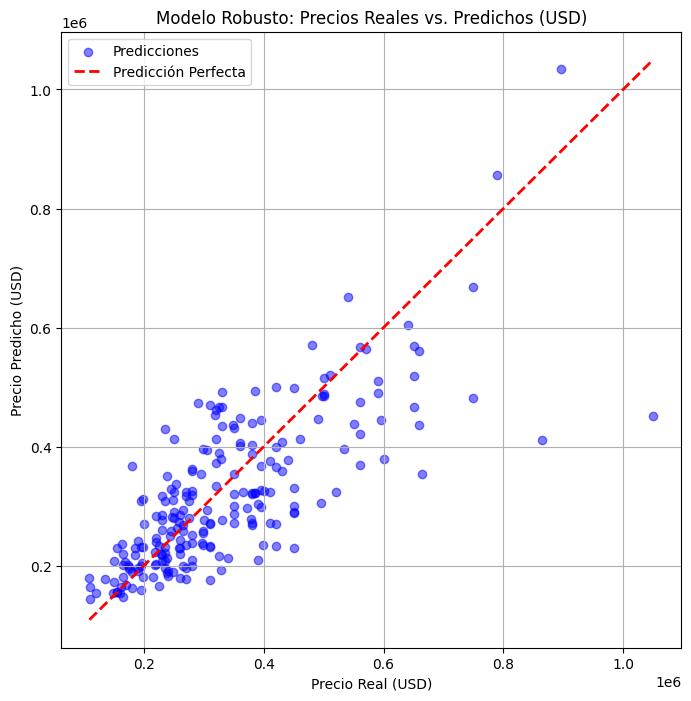

In [32]:
y_pred_log_val = model_v2.predict(X_val_proc).flatten()

y_pred_v2 = np.exp(y_pred_log_val)

r2_v2 = r2_score(y_val, y_pred_v2)
mape_v2 = mean_absolute_percentage_error(y_val, y_pred_v2) * 100
mediana_v2 = np.median(np.abs((y_val - y_pred_v2) / y_val)) * 100

print(f"R2 Score:        {r2_v2:.4f}")
print(f"Error Promedio:  {mape_v2:.2f}%")
print(f"Error Mediano:   {mediana_v2:.2f}%")


plt.figure(figsize=(8, 8))
plt.scatter(y_val, y_pred_v2, alpha=0.5, color='blue', label='Predicciones')
max_val = max(y_val.max(), y_pred_v2.max())
min_val = min(y_val.min(), y_pred_v2.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Predicción Perfecta')

plt.title('Modelo Robusto: Precios Reales vs. Predichos (USD)')
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.legend()
plt.grid(True)
plt.show()

COMPARATIVA DE RESULTADOS (Validación - USD Reales)
--- GB - Entrenado con Precio Crudo ---
R2 Score:        0.6910
Error Promedio:  18.65%
Error Mediano:   15.26%

--- GB - Entrenado con Logaritmo ---
R2 Score:        0.6840
Error Promedio:  17.01%
Error Mediano:   15.12%



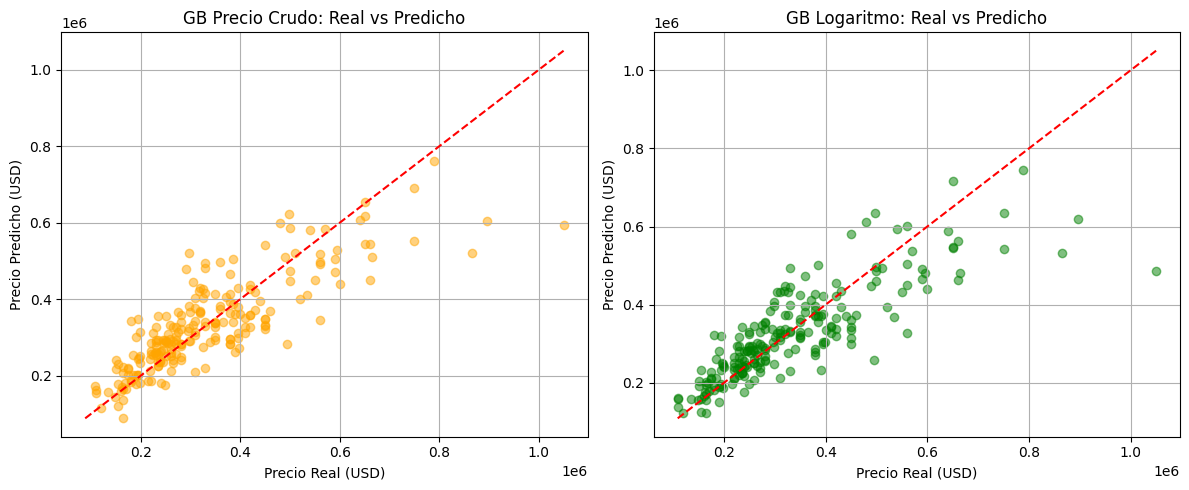

In [33]:
y_pred_raw = best_gb_raw.predict(X_val_proc)

y_pred_log_val = best_gb_log.predict(X_val_proc)
y_pred_log_exp = np.exp(y_pred_log_val)

def print_metrics(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mediana = np.median(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"--- {model_name} ---")
    print(f"R2 Score:        {r2:.4f}")
    print(f"Error Promedio:  {mape:.2f}%")
    print(f"Error Mediano:   {mediana:.2f}%\n")

print("COMPARATIVA DE RESULTADOS (Validación - USD Reales)")
print_metrics(y_val, y_pred_raw, "GB - Entrenado con Precio Crudo")
print_metrics(y_val, y_pred_log_exp, "GB - Entrenado con Logaritmo")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_val, y_pred_raw, alpha=0.5, color='orange')
max_val = max(y_val.max(), y_pred_raw.max())
min_val = min(y_val.min(), y_pred_raw.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.title('GB Precio Crudo: Real vs Predicho')
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_val, y_pred_log_exp, alpha=0.5, color='green')
max_val = max(y_val.max(), y_pred_log_exp.max())
min_val = min(y_val.min(), y_pred_log_exp.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.title('GB Logaritmo: Real vs Predicho')
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.grid(True)

plt.tight_layout()
plt.show()

# 6. TABLA DE MUESTRA DEL MEJOR ENFOQUE (Ejemplo con el Logarítmico)
resultados_comparativos = pd.DataFrame({
    'Precio Real USD': y_val.values,
    'Predicción Crudo USD': y_pred_raw.round(0),
    'Error Crudo %': ((y_pred_raw - y_val.values) / y_val.values * 100).round(1),
    'Predicción Log USD': y_pred_log_exp.round(0),
    'Error Log %': ((y_pred_log_exp - y_val.values) / y_val.values * 100).round(1)
})

COMPARATIVA DE RESULTADOS KNN (Validación - USD)
KNN - Entrenado con Precio Crudo
R2 Score:        0.5660
Error Promedio:  21.57%
Error Mediano:   18.66%

KNN - Entrenado con Logaritmo
R2 Score:        0.5820
Error Promedio:  20.77%
Error Mediano:   16.89%



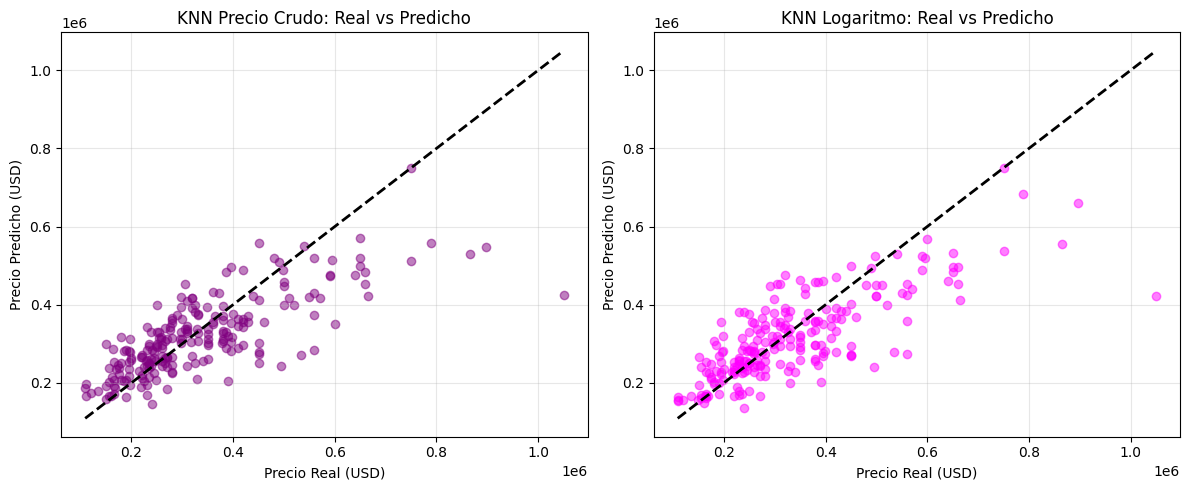

In [34]:
y_pred_raw = best_knn_raw.predict(X_val_proc)

y_pred_log_val = best_knn_log.predict(X_val_proc)
y_pred_log_exp = np.exp(y_pred_log_val)

def print_metrics(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mediana = np.median(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"{model_name}")
    print(f"R2 Score:        {r2:.4f}")
    print(f"Error Promedio:  {mape:.2f}%")
    print(f"Error Mediano:   {mediana:.2f}%\n")

print("COMPARATIVA DE RESULTADOS KNN (Validación - USD)")
print_metrics(y_val, y_pred_raw, "KNN - Entrenado con Precio Crudo")
print_metrics(y_val, y_pred_log_exp, "KNN - Entrenado con Logaritmo")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_val, y_pred_raw, alpha=0.5, color='purple')
max_val = max(y_val.max(), y_pred_raw.max())
min_val = min(y_val.min(), y_pred_raw.min())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
plt.title('KNN Precio Crudo: Real vs Predicho')
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_val, y_pred_log_exp, alpha=0.5, color='magenta')
max_val = max(y_val.max(), y_pred_log_exp.max())
min_val = min(y_val.min(), y_pred_log_exp.min())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
plt.title('KNN Logaritmo: Real vs Predicho')
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [35]:
y_pred_log_val = model_nn.predict(X_val_proc).flatten()
y_pred_val = np.exp(y_pred_log_val)

r2_val = r2_score(y_val, y_pred_val)
mape_val = mean_absolute_percentage_error(y_val, y_pred_val) * 100
mediana_val = np.median(np.abs((y_val - y_pred_val) / y_val)) * 100

print(f"R2 Score:        {r2_val:.4f}")
print(f"Error Promedio:  {mape_val:.2f}%")
print(f"Error Mediano:   {mediana_val:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R2 Score:        0.5463
Error Promedio:  18.92%
Error Mediano:   14.70%


RANKING MODELOS PREDICTIVOS
                           Modelo  R2 Score  Error Promedio (MAPE %)  \
1     Red Neuronal Ajustada (Log)    0.5463                    18.92   
2         Gradient Boosting (Log)    0.6840                    17.01   
3       Gradient Boosting (Crudo)    0.6910                    18.65   
4          Regresión Lineal (Log)    0.6087                    19.98   
5             Random Forest (Log)    0.6787                    19.59   
6                       KNN (Log)    0.5820                    20.77   
7           Random Forest (Crudo)    0.6547                    22.13   
8   Red Neuronal Robusta V2 (Log)    0.5642                    21.24   
9                     KNN (Crudo)    0.5660                    21.57   
10       Regresión Lineal (Crudo)    0.6221                    22.06   

    Error Mediano (%)  
1               14.70  
2               15.12  
3               15.26  
4               15.68  
5               15.84  
6               16.89  
7          

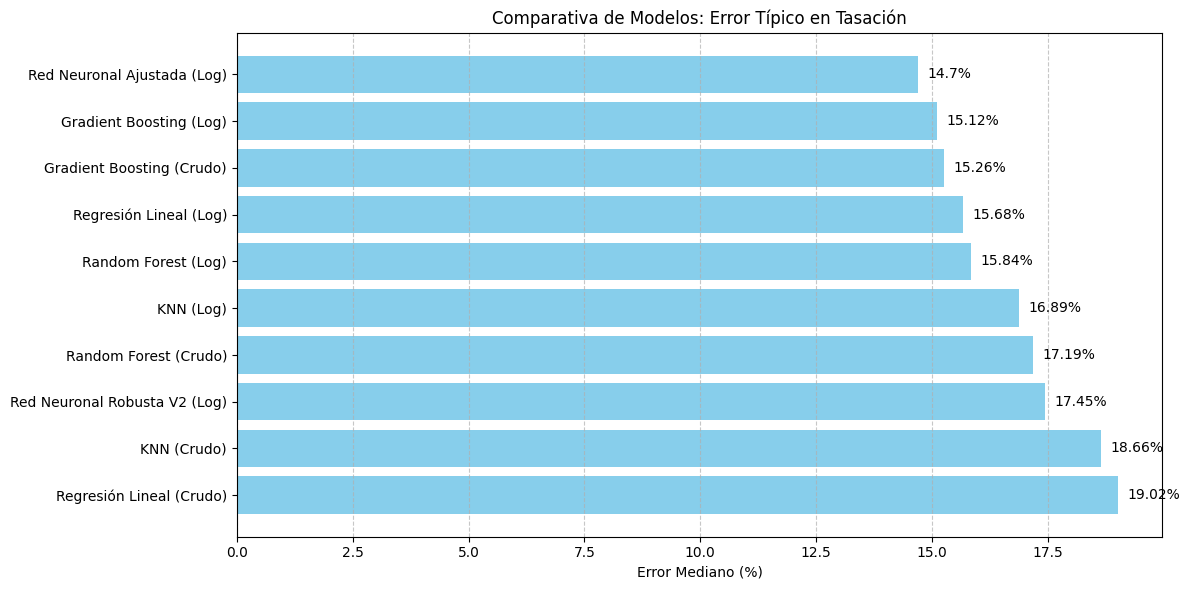

In [ ]:
resultados_campeonato = []

def evaluar_y_guardar(nombre_modelo, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mediana = np.median(np.abs((y_true - y_pred) / y_true)) * 100
    
    resultados_campeonato.append({
        'Modelo': nombre_modelo,
        'R2 Score': r2,
        'Error Promedio (MAPE %)': mape,
        'Error Mediano (%)': mediana
    })

evaluar_y_guardar('Regresión Lineal (Crudo)', y_val, model_lr.predict(X_val_proc))
evaluar_y_guardar('Regresión Lineal (Log)', y_val, np.exp(model_lr_log.predict(X_val_proc)))

evaluar_y_guardar('Random Forest (Crudo)', y_val, best_rf_normal.predict(X_val_proc))
evaluar_y_guardar('Random Forest (Log)', y_val, np.exp(best_rf_log.predict(X_val_proc)))

y_pred_nn = np.exp(model_nn.predict(X_val_proc, verbose=0).flatten())
evaluar_y_guardar('Red Neuronal Ajustada (Log)', y_val, y_pred_nn)

y_pred_v2 = np.exp(model_v2.predict(X_val_proc, verbose=0).flatten())
evaluar_y_guardar('Red Neuronal Robusta V2 (Log)', y_val, y_pred_v2)

evaluar_y_guardar('Gradient Boosting (Crudo)', y_val, best_gb_raw.predict(X_val_proc))
evaluar_y_guardar('Gradient Boosting (Log)', y_val, np.expm1(best_gb_log.predict(X_val_proc)))

evaluar_y_guardar('KNN (Crudo)', y_val, best_knn_raw.predict(X_val_proc))
evaluar_y_guardar('KNN (Log)', y_val, np.exp(best_knn_log.predict(X_val_proc)))

df_ranking = pd.DataFrame(resultados_campeonato)
df_ranking = df_ranking.sort_values(by='Error Mediano (%)', ascending=True).reset_index(drop=True)

df_ranking['R2 Score'] = df_ranking['R2 Score'].round(4)
df_ranking['Error Promedio (MAPE %)'] = df_ranking['Error Promedio (MAPE %)'].round(2)
df_ranking['Error Mediano (%)'] = df_ranking['Error Mediano (%)'].round(2)

df_ranking.index = df_ranking.index + 1

print("RANKING MODELOS PREDICTIVOS")
print(df_ranking)

plt.figure(figsize=(12, 6))
bars = plt.barh(df_ranking['Modelo'][::-1], df_ranking['Error Mediano (%)'][::-1], color='skyblue')
plt.xlabel('Error Mediano (%)')
plt.title('Comparativa de Modelos: Error Típico en Tasación')
plt.grid(axis='x', linestyle='--', alpha=0.7)

for bar in bars:
    plt.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width()}%', va='center', ha='left', fontsize=10)

plt.tight_layout()
plt.show()